# install and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#add path here to run notebook
path="/content/drive/MyDrive/coraline/"

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# EDA

In [ ]:
calendar=reduce_mem_usage(pd.read_csv(f"{path}calendar.csv"))
sales_train=pd.read_csv(f"{path}sales_train_evaluation.csv")
sell_price=reduce_mem_usage(pd.read_csv(f"{path}sell_prices.csv"))
submission = reduce_mem_usage(pd.read_csv(f"{path}sample_submission.csv"))

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


Export calendar


In [ ]:
#combine all event to count type
event_type_1=calendar.groupby("year")["event_type_1"].value_counts().unstack(1)
event_type_2=calendar.fillna(0).groupby("year")["event_type_2"].value_counts().unstack(1).drop(0,1)
event=event_type_1.copy()
for col in event_type_2.columns:
    event[col]=event_type_2[col].fillna(0)+event[col]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


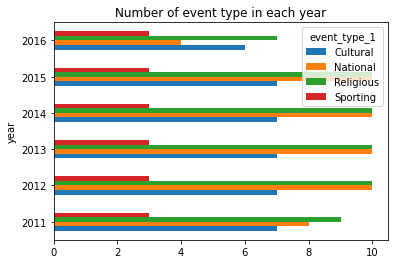

In [ ]:
#plot number  type of event
event.plot.barh(title="Number of event type in each year")

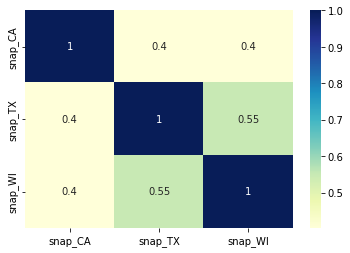

In [ ]:
#corr between each product
calendar_snap=calendar[["snap_CA","snap_TX","snap_WI"]]
sb.heatmap(calendar_snap.corr(), cmap="YlGnBu", annot=True)

explore sell price

In [ ]:
def unstack_item_id(text):
  t=text.split("_")
  return t[0],t[1],t[2]

In [ ]:
sell_price["item_id_1"],sell_price["item_id_2"],sell_price["item_id_3"]=np.vectorize(unstack_item_id)(sell_price["item_id"])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


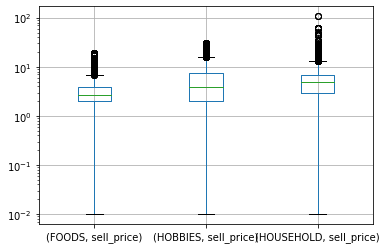

In [ ]:
#sale price with item_id
sell_price[["sell_price","item_id_1"]].groupby("item_id_1").boxplot(subplots=False).set_yscale('log')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


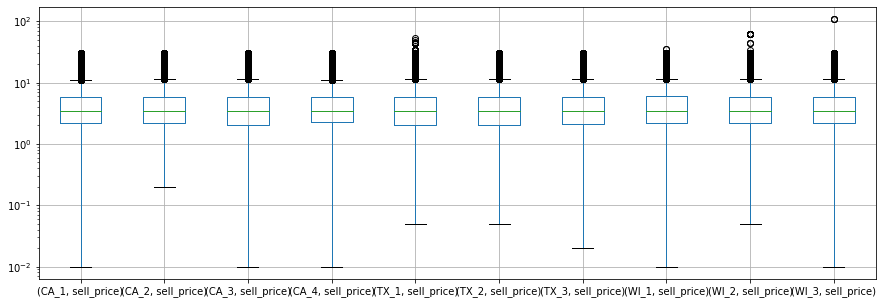

In [ ]:
#sale price with store_id
sell_price[["sell_price","store_id"]].groupby("store_id").boxplot(subplots=False,figsize=(15,5)).set_yscale('log')

explore sales_train_evaluation|

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


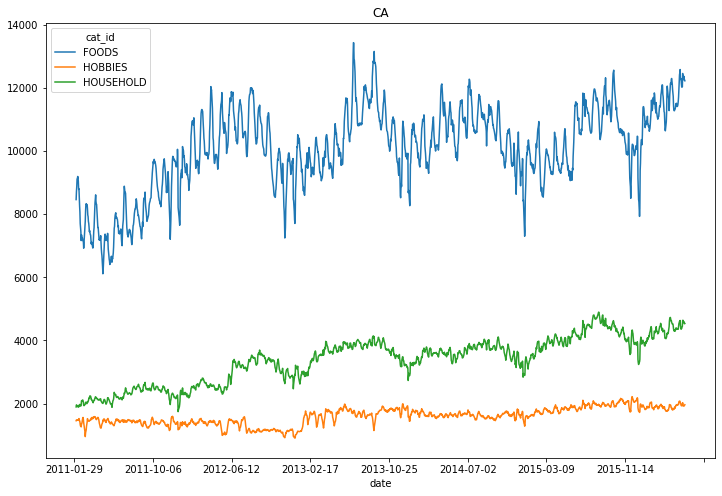

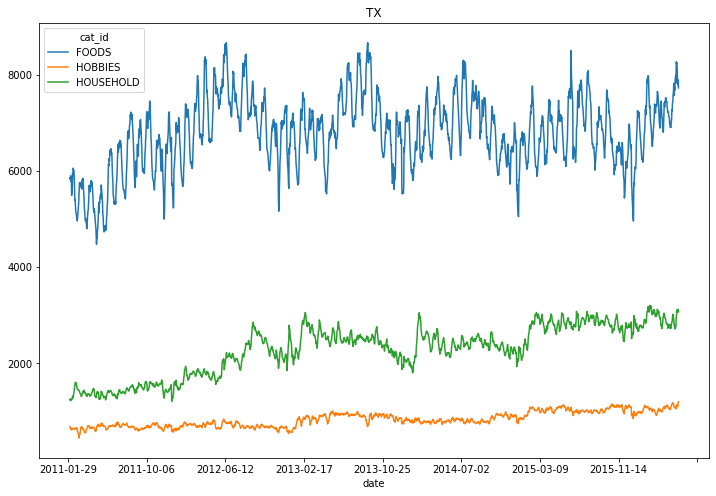

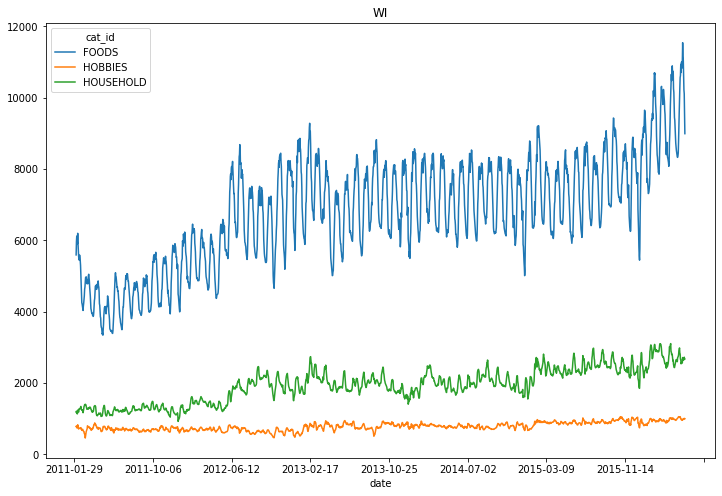

In [ ]:
state_id=["CA","TX","WI"]
for s_id in state_id:
  store_agg = sales_train[sales_train["state_id"]==s_id].drop(['id','item_id','dept_id',"store_id"],axis=1).groupby(['cat_id']).sum()
  store_agg.columns=  calendar['date'].head(1941)
  print(store_agg.transpose().rolling(window=7).mean().plot(title=s_id,figsize=(12,8)))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


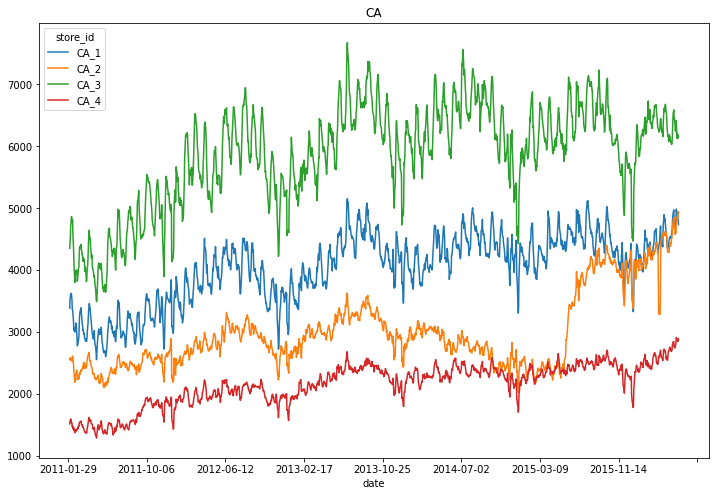

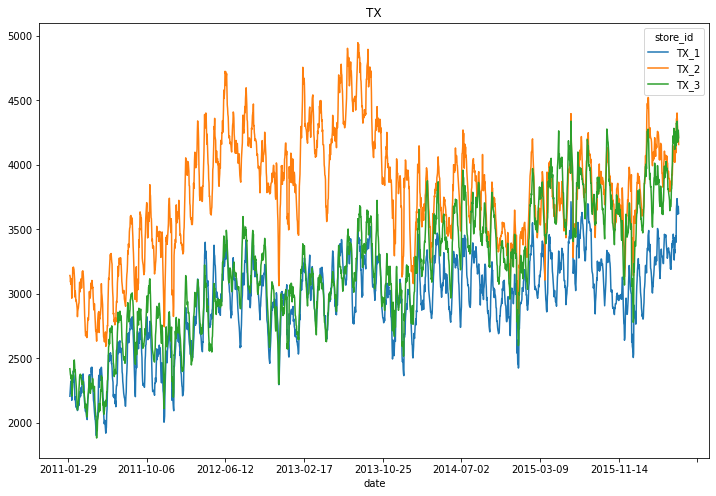

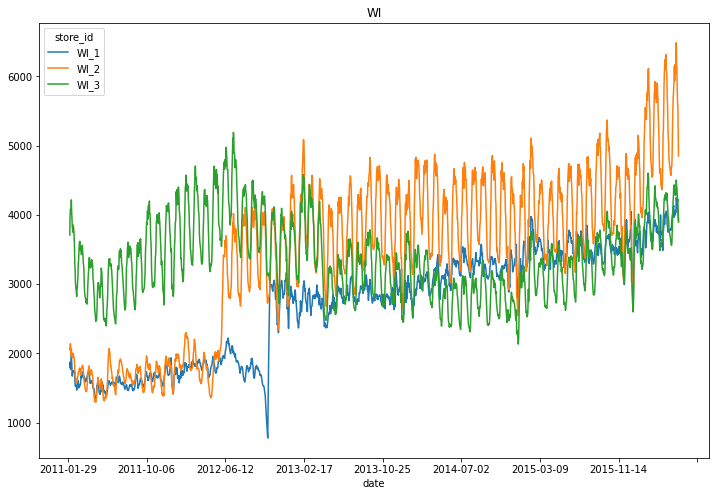

In [ ]:
state_id=["CA","TX","WI"]
for s_id in state_id:
  store_agg = sales_train[sales_train["state_id"]==s_id].drop(['id','item_id','dept_id',"cat_id"],axis=1).groupby(["store_id"]).sum()
  store_agg.columns=  calendar['date'].head(1941)
  print(store_agg.transpose().rolling(window=7).mean().plot(title=s_id,figsize=(12,8)))

AxesSubplot(0.125,0.125;0.775x0.755)


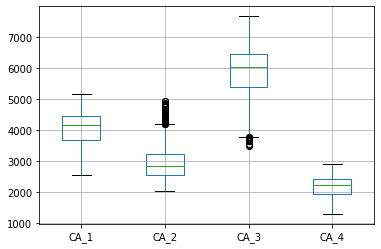

In [ ]:
store_agg = sales_train[sales_train["state_id"]=="CA"].drop(['id','item_id','dept_id',"cat_id"],axis=1).groupby(["store_id"]).sum()
store_agg.columns=  calendar['date'].head(1941)
print(store_agg.transpose().rolling(window=7).mean().boxplot())

AxesSubplot(0.125,0.125;0.775x0.755)


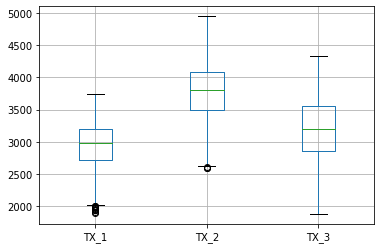

In [ ]:
store_agg = sales_train[sales_train["state_id"]=="TX"].drop(['id','item_id','dept_id',"cat_id"],axis=1).groupby(["store_id"]).sum()
store_agg.columns=  calendar['date'].head(1941)
print(store_agg.transpose().rolling(window=7).mean().boxplot())

AxesSubplot(0.125,0.125;0.775x0.755)


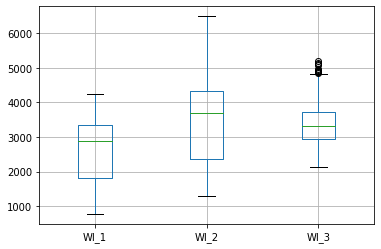

In [ ]:
store_agg = sales_train[sales_train["state_id"]=="WI"].drop(['id','item_id','dept_id',"cat_id"],axis=1).groupby(["store_id"]).sum()
store_agg.columns=  calendar['date'].head(1941)
print(store_agg.transpose().rolling(window=7).mean().boxplot())

# Preprocessing

In [ ]:
sales_train = reduce_mem_usage(pd.melt(sales_train,
                                 id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                 var_name = 'day',
                                 value_name = 'demand'))

Mem. usage decreased to 3273.49 Mb (9.4% reduction)


[](http://)

In [ ]:
test2_rows = [row for row in submission['id'] if 'evaluation' in row]
test2 = submission[submission['id'].isin(test2_rows)]

test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                  'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

product = sales_train[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()


test2 = test2.merge(product, how = 'left', on = 'id')

test2 = pd.melt(test2, 
                id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', 
                value_name = 'demand')

sales_train['part'] = 'train'
test2['part'] = 'test'

In [ ]:
id_sub=test2[["id","day"]]

In [ ]:
del test2_rows[:]
del test2_rows

In [ ]:
sales_train = pd.concat([sales_train,test2], axis = 0)
del test2,product
gc.collect()

3948

In [ ]:
def day_2(text):
    return int(text.split("_")[1])
sales_train["day_2"]=np.vectorize(day_2)(sales_train["day"])

In [ ]:
#delete data to 1.5 year due to ram memory
sales_train=sales_train[sales_train["day_2"]>1969-(365*2+28)].drop(columns="day_2")
sales_train.reset_index(drop=True,inplace=True)

In [ ]:
calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
data = reduce_mem_usage(sales_train)

Mem. usage decreased to 1454.69 Mb (0.0% reduction)


In [ ]:
data = pd.merge(sales_train, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

In [ ]:
data = data.merge(sell_price, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
del calendar,sell_price
gc.collect()

50

In [ ]:
nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    data[feature].fillna('unknown', inplace = True)

encoding

In [ ]:
def endcoding(data):
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    return data

In [ ]:
data=endcoding(data)

In [ ]:
data.drop(columns=['item_id_1', 'item_id_2','item_id_3'], inplace = True, axis = 1)

In [ ]:
def add_feature(data):
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7']   = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_mean_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    def weekend(arg):
        if arg==5 or arg==6:
            return 1
        else:
            return 0
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std()) 
    data['isweekend'] = data['dayofweek'].apply(weekend)
    data=data.dropna()
    data.drop(columns=["wm_yr_wk","cat_id","state_id","item_id"], inplace = True, axis = 1)
  
    return data

In [ ]:
data=add_feature(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# feature selection

In [ ]:
y=data[data["part"]=="train"]["demand"]
temp=data.copy()
X=temp[temp["part"]=="train"].drop(columns=["demand","part","id","date"])
del temp

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'learning_rate': 0.1}
gbm = lgb.LGBMRegressor(**params)
gbm.fit(X, y)
gbm.booster_.feature_importance()
# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':X.columns, 'fea_imp':gbm.feature_importances_})

<BarContainer object of 22 artists>

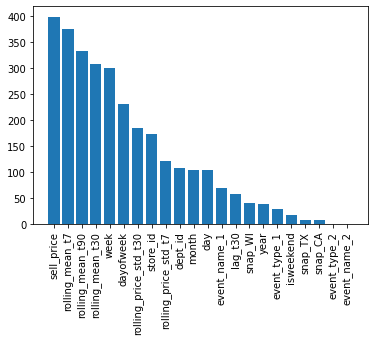

In [ ]:
fea_imp_=fea_imp_.sort_values(by=['fea_imp'], ascending = False)
plt.xticks(rotation=90)
plt.bar(height=fea_imp_["fea_imp"],x=fea_imp_["cols"])

In [ ]:
fea_imp_[fea_imp_["fea_imp"]>50]["cols"].unique()

array(['sell_price', 'rolling_mean_t7', 'rolling_mean_t90',
       'rolling_mean_t30', 'week', 'dayofweek', 'rolling_price_std_t30',
       'store_id', 'rolling_price_std_t7', 'dept_id', 'month', 'day',
       'event_name_1', 'lag_t30'], dtype=object)

In [ ]:
def delete_columns(data):
    return data.drop(columns=fea_imp_[fea_imp_["fea_imp"]<50]["cols"].unique())

In [ ]:
data= delete_columns(data)

In [ ]:
features=[ 'dept_id', 'store_id', 'event_name_1',
       'sell_price', 'lag_t30', 'rolling_mean_t7', 'rolling_mean_t30',
       'rolling_mean_t90', 'month', 'week', 'day', 'dayofweek',
       'rolling_price_std_t7', 'rolling_price_std_t30']

# Evaluation

In [ ]:
def CV_custome(data):
    data=data.reset_index(drop=True)
    train_ind=[list(data[(data['date'] <= '2016-02-28')].index),
              list(data[(data['date'] <= '2016-03-27')].index),
              list(data[(data['date'] <= '2016-04-24')].index)]

    test_ind=[list(data[(data['date'] <= '2016-03-27') & (data['date'] >= '2016-02-29')].index),
             list(data[(data['date'] <= '2016-04-24') & (data['date'] >= '2016-03-28')].index),
             list(data[(data['date'] > '2016-04-24')& (data['part'] == 'train')].index)]
    return  train_ind,test_ind

In [ ]:
train_ind,test_ind=CV_custome(data)

In [ ]:
#check cv_custome
for i in [0,1,2]:
  print(train_ind[i][0],train_ind[i][-1])
  print(test_ind[i][0],test_ind[i][-1])
  print("finsih: ",i+1)

0 15859423
15859424 16713039
finsih:  1
0 16713039
16713040 17566759
finsih:  2
0 17566759
17566760 18420479
finsih:  3


In [ ]:
par={
    'metric': ['rmse'],
    'objective': ["regression"],
    'boosting_type': ["gbdt"],
    'learning_rate':[0.3,0.1,0.03],
     "n_estimators":[50,100,150]
    }

In [ ]:
from sklearn.metrics import make_scorer,mean_squared_error
from math import sqrt
def rmse(y_true, y_pred):
    return sqrt(np.square(np.subtract(y_true,y_pred).mean())) 
rmse_score = make_scorer(rmse, greater_is_better=False)

In [ ]:
data=data.reset_index(drop=True)
y_train=data[data["part"]=="train"]["demand"]
X_train=data[data["part"]=="train"][features]

In [114]:
model=lgb.LGBMRegressor()
rs=RandomizedSearchCV(estimator=model, param_distributions = par, cv =zip(train_ind,test_ind ),scoring=rmse_score,verbose=3,n_iter=5)
rs.fit(X_train, y_train)
best_params = rs.best_params_
best_score = rs.best_score_
print('Best Hyperparameters: %s' %best_params)
print('Best score: %s' %best_score)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END boosting_type=gbdt, learning_rate=0.03, metric=rmse, n_estimators=100, objective=regression;, score=-0.062 total time= 1.3min
[CV 2/3] END boosting_type=gbdt, learning_rate=0.03, metric=rmse, n_estimators=100, objective=regression;, score=-0.035 total time= 1.3min
[CV 3/3] END boosting_type=gbdt, learning_rate=0.03, metric=rmse, n_estimators=100, objective=regression;, score=-0.075 total time= 1.4min
[CV 1/3] END boosting_type=gbdt, learning_rate=0.3, metric=rmse, n_estimators=200, objective=regression;, score=-0.051 total time= 1.4min
[CV 2/3] END boosting_type=gbdt, learning_rate=0.3, metric=rmse, n_estimators=200, objective=regression;, score=-0.003 total time= 1.5min
[CV 3/3] END boosting_type=gbdt, learning_rate=0.3, metric=rmse, n_estimators=200, objective=regression;, score=-0.069 total time= 1.6min
[CV 1/3] END boosting_type=gbdt, learning_rate=0.03, metric=rmse, n_estimators=500, objective=regression;, sc

In [115]:
x_val_test = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')][features]
y_val_test = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')]['demand']

In [116]:
X_val_train = data[(data['date'] <= '2016-04-24') & (data['part'] == 'train')][features]
y_val_train = data[(data['date'] <= '2016-04-24') & (data['part'] == 'train')]['demand']

In [130]:
model=lgb.LGBMRegressor(**best_params)
model.fit(X_val_train,y_val_train)
y_val_pred=model.predict(x_val_test)

In [131]:
print(rmse(y_val_test,y_val_pred))

0.05757189686879749


In [132]:
val_id=data[(data['date'] > '2016-04-24') & (data['part'] == 'train')][["id","date"]]
val_id["demand"] = y_val_pred

In [133]:
validatuin=val_id.pivot("id","date","demand")
validatuin=validatuin.reset_index()
validatuin["id"]=validatuin["id"].str.replace("evaluation","validation")
validatuin=validatuin.set_index("id")
validatuin.columns=['F1', 'F2','F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10','F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18','F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27','F28']
validatuin    

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,0.773029,0.718661,0.674436,0.674436,0.892778,1.095345,1.158178,0.949998,0.975352,1.039729,0.992916,1.019595,1.275811,1.354109,1.003827,0.940130,0.886583,0.913450,0.969137,1.267588,1.187525,0.999559,0.962031,0.947754,0.927531,1.030308,1.257556,1.269883
FOODS_1_001_CA_2_validation,0.826484,0.727526,0.723420,0.723420,0.793673,0.900630,0.959087,0.698303,0.684233,0.721346,0.701805,0.781950,0.968363,0.907847,0.700891,0.640235,0.640235,0.640235,0.721983,0.908396,1.716598,1.271585,1.161243,1.118223,1.345905,1.534930,1.923121,1.456317
FOODS_1_001_CA_3_validation,1.239108,1.121171,1.096695,1.078173,1.134991,1.058691,1.138431,0.946538,0.907025,0.868861,0.849320,0.933446,1.269586,1.300902,1.104958,1.065445,1.018395,0.962345,1.034978,1.100870,1.787682,1.281865,1.173713,1.105345,1.105345,1.199803,1.614510,1.127676
FOODS_1_001_CA_4_validation,0.398700,0.365665,0.327794,0.327794,0.362240,0.370043,0.437456,0.389511,0.366003,0.321468,0.301927,0.372152,0.423210,0.325401,0.276464,0.252956,0.237357,0.237357,0.268278,0.305938,0.292071,0.276378,0.233632,0.209448,0.209448,0.281275,0.396564,0.433889
FOODS_1_001_TX_1_validation,0.569515,0.536480,0.511231,0.511231,0.427554,0.460988,0.519326,0.480027,0.472118,0.410240,0.390699,0.416806,0.472353,0.447672,0.370956,0.305355,0.305355,0.280679,0.304164,0.345844,0.345844,0.245368,0.210723,0.206089,0.206089,0.248997,0.307111,0.307111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_516_TX_2_validation,0.261175,0.228140,0.257798,0.257798,0.270466,0.331329,0.324323,0.271949,0.286160,0.247221,0.200976,0.263424,0.301084,0.346703,0.299973,0.247221,0.247221,0.247221,0.297906,0.428517,0.402024,0.276139,0.245166,0.260626,0.260626,0.311310,0.337004,0.304169
HOUSEHOLD_2_516_TX_3_validation,0.141309,0.144367,0.165123,0.151919,0.186366,0.204471,0.232639,0.210138,0.178529,0.160734,0.141193,0.199432,0.744421,0.697780,0.755401,0.755527,0.772747,0.772747,0.990363,0.313020,0.313020,0.327739,0.304866,0.304866,0.304866,0.402402,0.432126,0.432126
HOUSEHOLD_2_516_WI_1_validation,0.124442,0.103872,0.099766,0.099766,0.118533,0.143077,0.154927,0.141725,0.122581,0.104785,0.089672,0.123553,0.163211,0.148097,0.123930,0.104785,0.104785,0.104785,0.139152,0.178810,0.178810,0.139406,0.120897,0.120897,0.120897,0.124065,0.163723,0.163723


# predict

In [145]:
y=data[data["part"]=="train"]["demand"]
X=data[data["part"]=="train"][features]
model=lgb.LGBMRegressor(**best_params)
model.fit(X,y)
X_pred=data[data["part"]=="test"][features]
y_pred=model.predict(X_pred)
id_sub["demand"]=y_pred

In [147]:
d= ['d_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                  'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
dict_map={}
for i in range(0,len(d)):
    dict_map[d[i]]="F"+str(i+1)
id_sub["days"]=id_sub["day"].map(dict_map)  

In [148]:
sub=id_sub.pivot("id","days","demand")

In [149]:
sub=sub[['F1', 'F2','F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10','F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18','F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27','F28']]

In [150]:
subs=pd.concat([validatuin,sub])

In [151]:
subs.to_csv("coraline_submission_v6.csv")